In [0]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [0]:
transforms = transforms.Compose([transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                         std=[0.5, 0.5, 0.5]),
                    ])

dataset_ = datasets.CIFAR10(root='dataset', transform=transforms, download=True)
train_data_loader = torch.utils.data.DataLoader(dataset_, batch_size=128, shuffle=True)

Files already downloaded and verified


In [0]:
images, labels = next(iter(train_data_loader))

In [0]:
images.shape

torch.Size([128, 3, 32, 32])

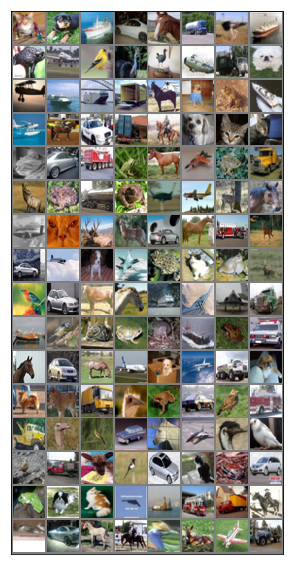

In [0]:
def image_display(image, title=None):
    image = image/2 + 0.5
    numpy_image = image.numpy()
    transposed_numpy_image = np.transpose(numpy_image, (1, 2, 0))
    plt.figure(figsize=(30, 10))
    plt.imshow(transposed_numpy_image)
    plt.yticks([])
    plt.xticks([])
    if title:
        plt.title(title)
    plt.show
    
image_display(torchvision.utils.make_grid(images))

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
device

device(type='cuda', index=0)

In [0]:
class Generator(nn.Module):
    
    def __init__(self, latent_vector):
        
        super(Generator, self).__init__()
        
        self.latent_vector = latent_vector
        
        self.fully_connected_layer = nn.Sequential(nn.Linear(self.latent_vector, 512*4*4),
                                              nn.ReLU())
        
        self.first_deconvolutional_layer = nn.Sequential(nn.ConvTranspose2d(512, 256, kernel_size=4, padding=1, stride=2),
                                                    nn.BatchNorm2d(256),
                                                    nn.ReLU())
        
        self.second_deconvolutional_layer = nn.Sequential(nn.ConvTranspose2d(256, 128, kernel_size=4, padding=1, stride=2),
                                                     nn.BatchNorm2d(128),
                                                     nn.ReLU())
        
        self.third_deconvolutional_layer = nn.ConvTranspose2d(128, 3, kernel_size=4, padding=1, stride=2)
        
        
    def forward(self, x):
        
        x = x.view(x.size(0), -1)
        
        x = self.fully_connected_layer(x)
        
        x = x.view(x.shape[0], 512, 4, 4)
        
        x = self.first_deconvolutional_layer(x)
        
        x = self.second_deconvolutional_layer(x)
        
        x = self.third_deconvolutional_layer(x)
        
        generator_output = torch.tanh(x)
        
        return generator_output

In [0]:
x = torch.randn(size=(10, 100))

In [0]:
xx = Generator(100)(x)

In [0]:
class Discriminator(nn.Module):
    
    def __init__(self):
        
        super(Discriminator, self).__init__()
        
        self.first_convolutional_layer = nn.Sequential(nn.Conv2d(3, 128, kernel_size=4, padding=1, stride=2))
        
        self.second_convolutional_layer = nn.Sequential(nn.Conv2d(128, 256, kernel_size=4, padding=1, stride=2),
                                                        nn.BatchNorm2d(256),
                                                        nn.LeakyReLU(negative_slope=0.2))
        
        self.third_convolutional_layer = nn.Sequential(nn.Conv2d(256, 512, kernel_size=4, padding=1, stride=2),
                                                        nn.BatchNorm2d(512),
                                                        nn.LeakyReLU(negative_slope=0.2))
        
        self.fully_connected_layer = nn.Linear(512*4*4, 1)
        
        
    def forward(self, x):
        
        x = self.first_convolutional_layer(x)
        
        x = self.second_convolutional_layer(x)
        
        x = self.third_convolutional_layer(x)
        
        x = x.view(x.size(0), -1)
        
        discriminator_output = self.fully_connected_layer(x)
        
        return discriminator_output
        

In [0]:
latent_vector_size = 100

In [0]:
G = Generator(latent_vector_size).to(device)
D = Discriminator().to(device)

In [0]:
type(G.third_deconvolutional_layer)

torch.nn.modules.conv.ConvTranspose2d

In [0]:
def weight_initializer(m):
    
    if type(m) == nn.Linear:
        
        nn.init.normal_(m.weight.data, 0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
    elif type(m) == nn.Conv2d:
        
        nn.init.normal_(m.weight.data, 0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
    elif type(m) == nn.ConvTranspose2d:
        
        nn.init.normal_(m.weight.data, 0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
    elif type(m) == nn.BatchNorm2d:
        
        nn.init.normal_(m.weight.data, 0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
D.apply(weight_initializer)

Discriminator(
  (first_convolutional_layer): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (second_convolutional_layer): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (third_convolutional_layer): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (fully_connected_layer): Linear(in_features=8192, out_features=1, bias=True)
)

In [0]:
G.apply(weight_initializer)

Generator(
  (fully_connected_layer): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): ReLU()
  )
  (first_deconvolutional_layer): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (second_deconvolutional_layer): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (third_deconvolutional_layer): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [0]:
D_learning_rate = 0.0002
G_learning_rate = 0.0002
b1 = 0.5
b2 = 0.99
optimizer_generator = torch.optim.Adam(G.parameters(), lr=G_learning_rate, betas=[b1, b2])
optimizer_discriminator = torch.optim.Adam(D.parameters(), lr=D_learning_rate)
criteria = nn.BCEWithLogitsLoss()

In [0]:
def real_loss(discriminator_output):
    
    true_target = torch.ones(discriminator_output.size(0), 1).to(device)
    loss = criteria(discriminator_output, true_target)
    
    return loss
    
    
    
def fake_loss(discriminator_output):
    
    true_target = torch.zeros(discriminator_output.size(0), 1).to(device)
    loss = criteria(discriminator_output, true_target)
    
    return loss

In [0]:
def latent_vector_creator():
    random_numbers = np.random.uniform(-1, 1, size=(train_data_loader.batch_size, 100))
    return torch.from_numpy(random_numbers).float().to(device)

In [0]:
def test_latent_vector(numbers_of_samples):
    random_numbers = np.random.uniform(-1, 1, size=(numbers_of_samples, 100))
    return torch.from_numpy(random_numbers).float().to(device)

In [0]:
number_of_epoch = 100
discriminator_loss_array = []
generator_loss_array = []
generated_images_array = []
fixed_test_samples = test_latent_vector(16)

for i in range(number_of_epoch):
    fixed_train_samples = test_latent_vector(train_data_loader.batch_size)
    total_discriminator_loss = 0
    total_generator_loss = 0
    
#   setting the network to training mode
    D.train()
    G.train()
    
    for real_images, _ in train_data_loader:
        
#       set the image values to be betwwen -1 and 1
        real_images = real_images*2 - 1
        
        real_images = real_images.to(device)
        
#       Discriminator training code
        optimizer_discriminator.zero_grad()

#       The code below help to get the discriminator real loss  
        discriminator_real_image_logit = D(real_images)
        
        discriminator_real_loss = real_loss(discriminator_real_image_logit)
         
#       The code below helps to get the discriminator fake loss
        fake_outputs_from_generator = G(fixed_train_samples)
        
        discriminator_fake_image_logit = D(fake_outputs_from_generator)
        
        discriminator_fake_loss = fake_loss(discriminator_real_image_logit)
        
#       The discriminator loss
        discriminator_loss = discriminator_real_loss + discriminator_fake_loss
        
        discriminator_loss.backward(retain_graph=True)
        
        optimizer_discriminator.step()
        
        total_discriminator_loss += discriminator_loss.item() * train_data_loader.batch_size
#       End of discriminator training code
#         
#         
#                    
#       Generator training code
        optimizer_generator.zero_grad()
    
#       The code below helps to get the generator loss
        outputs_from_generator = G(latent_vector_creator())
        
        generator_logit = D(outputs_from_generator)
          
#       The generator loss
        generator_loss = real_loss(generator_logit)
        
        generator_loss.backward()
        
        optimizer_generator.step()
        
        total_generator_loss += generator_loss.item() * train_data_loader.batch_size
#       End of Generator training code
# 
# 
#     
#   This computes the total discriminator loss and also append it to an array
    total_discriminator_loss_per_epoch = round(total_discriminator_loss/len(train_data_loader.dataset), 5)
    discriminator_loss_array.append(total_discriminator_loss_per_epoch)
    
#   This computes the total generators loss and also append it to an array
    total_generator_loss_per_epoch = round(total_generator_loss/len(train_data_loader.dataset), 5)
    generator_loss_array.append(total_generator_loss_per_epoch)
    
#   print training results
    print(f'{i+1}/{number_of_epoch} The generator loss: {total_generator_loss_per_epoch}... The discriminator loss: {total_discriminator_loss_per_epoch}')
#     
#     
#     
#   Here we will use the Generator to create fake images after each epoch to see it's performance 
    G.eval()
    generated_samples = G(fixed_test_samples)
    generated_images_array.append(generated_samples)
#     
#     
#    
#   Here will dump the generated_images_array into a pickle
with open('image_generated.pkl', 'wb') as f:
    pickle.dump(generated_images_array, f)

1/100 The generator loss: 0.5168... The discriminator loss: 1.38763
2/100 The generator loss: 0.51856... The discriminator loss: 1.38763
3/100 The generator loss: 0.52125... The discriminator loss: 1.38763
4/100 The generator loss: 0.52692... The discriminator loss: 1.38763
5/100 The generator loss: 0.53148... The discriminator loss: 1.38763
6/100 The generator loss: 0.53385... The discriminator loss: 1.38763
7/100 The generator loss: 0.53798... The discriminator loss: 1.38763
8/100 The generator loss: 0.54174... The discriminator loss: 1.38763
9/100 The generator loss: 0.54458... The discriminator loss: 1.38763
10/100 The generator loss: 0.54708... The discriminator loss: 1.38763
11/100 The generator loss: 0.55087... The discriminator loss: 1.38763
12/100 The generator loss: 0.55361... The discriminator loss: 1.38763
13/100 The generator loss: 0.55675... The discriminator loss: 1.38763
14/100 The generator loss: 0.55978... The discriminator loss: 1.38763
15/100 The generator loss: 0.5

In [0]:
x_axis = (range(number_of_epoch))

plt.plot(x_axis, generator_loss_array, 'r', discriminator_loss_array, 'b')

plt.title('A gragh of training loss vs validation loss')

plt.legend(['generator_loss_array', 'discriminator_loss_array'])

plt.xlabel('Number of Epochs')

plt.ylabel('Generator_Loss and discriminator_loss')

In [0]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [0]:
with open('image_generated.pkl', 'rb') as f:
    generated_samples = pickle.load(f)

In [0]:
view_samples(-1, generated_samples)